# 

In [1]:
from Movement_functions import *
from Color_functions import coincidencia, video_otsu_a
from skimage import io, measure
import matplotlib.pyplot as plt
plt.gray()

<Figure size 640x480 with 0 Axes>

In [2]:
M_t = matriz_de_movimiento("videos5fps/controlled3.avi")

In [3]:
F_t = video_otsu_a("videos5fps/controlled3.avi")

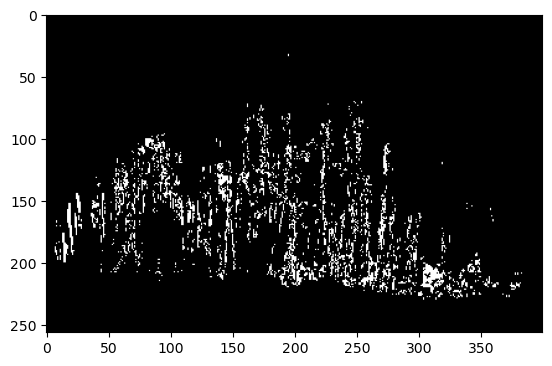

In [4]:
plt.imshow(F_t[25]&M_t[25])

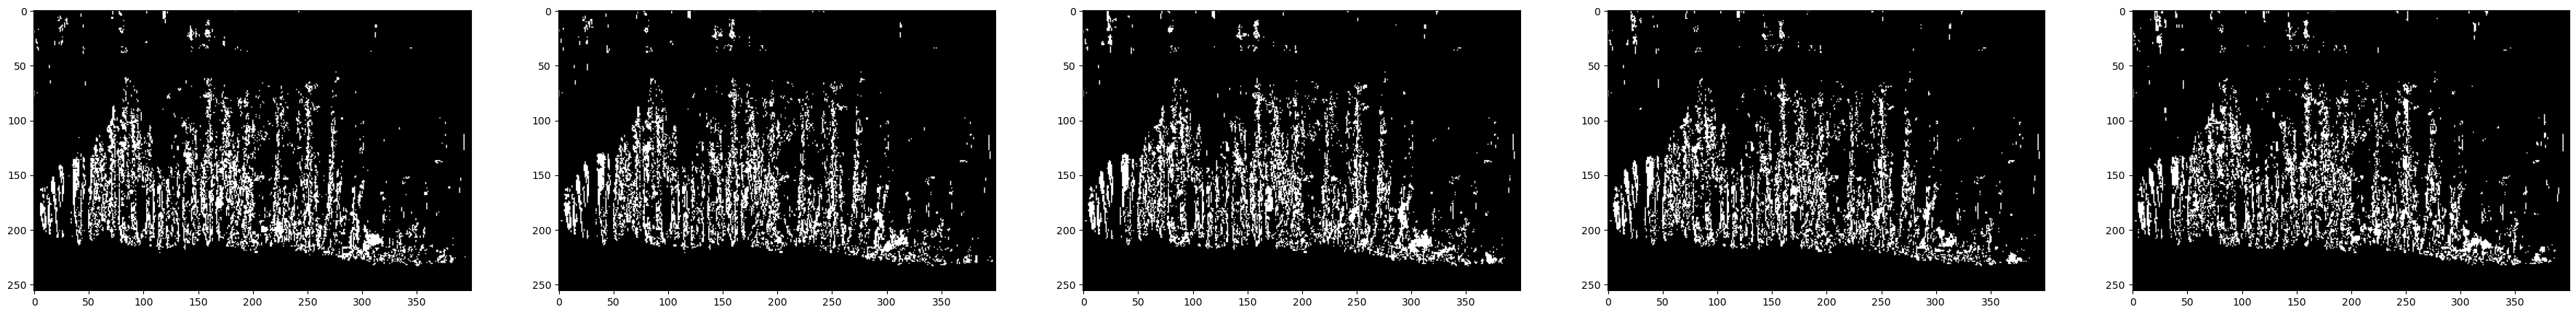

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(45,65))

# Plotteo un par de ejemplos de la lista de M 
for i in range(30,35):
    axes[i-30].imshow(M_t[i])

plt.show()

In [6]:
C = [M_t[i]&F_t[i] for i in range(len(M_t))]

In [8]:
comps = componentes_que_crecen(np.array(C[:10]), tiempo_buffer=5, min_crecimiento=.4, min_area=10)

Procesado hasta frame  5
Procesado hasta frame  6
Procesado hasta frame  7
Procesado hasta frame  8
Procesado hasta frame  9


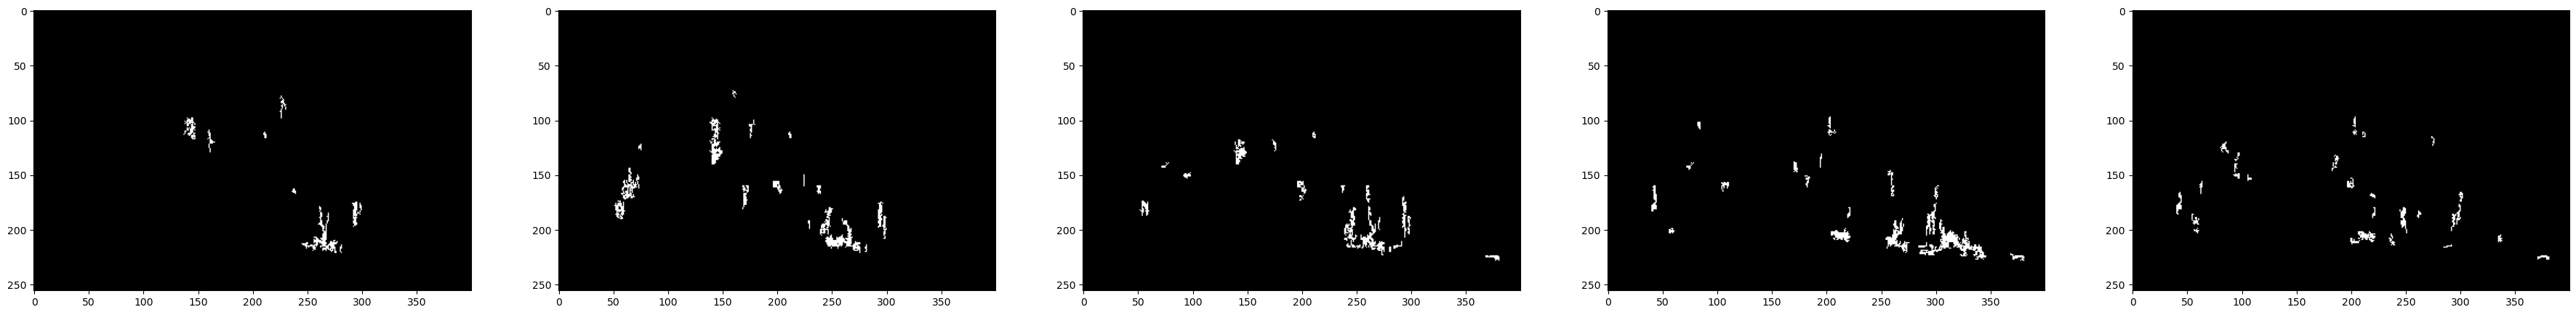

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(45,45))

for i in range(5):
    axes[i].imshow(comps[i])